# Stability calculations

## -- LUVOIR --

In notebook 10, we calculated the PASTIS modes for all three currently designed apodizers for the LUVOIR A pupil. In this notebook, we will load the modes and calculate the maximum mode contributions $\sigma$ and strability requirements $\Delta \sigma$.

After that I also calculate the maximum segment contributions $\mu$.

In [1]:
# Imports
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline
from astropy.io import fits
import astropy.units as u
import hcipy as hc

os.chdir('../../pastis/')
import util_pastis as util
from e2e_simulators.luvoir_imaging_onephot import LuvoirAPLC

In [2]:
plt.rcParams['font.family'] = "sans-serif"
plt.rcParams["font.sans-serif"] = ["Computer Modern Sans"]
plt.rcParams["text.usetex"] = True
plt.rcParams["text.latex.preamble"] = r"\usepackage{cmbright}"
plt.rcParams['font.size'] = 16
plt.rcParams['axes.labelsize'] = 22
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['figure.titlesize'] = 16

In [3]:
# Load aperture files needed for SM
nseg = 120
wvln = 638e-9

datadir = '/Users/pueyo/PythonPackages/PASTIS/LUVOIR_delivery_May2019/'
aper_path = 'inputs/TelAp_LUVOIR_gap_pad01_bw_ovsamp04_N1000.fits'
aper_ind_path = 'inputs/TelAp_LUVOIR_gap_pad01_bw_ovsamp04_N1000_indexed.fits'
aper_read = hc.read_fits(os.path.join(datadir, aper_path))
aper_ind_read = hc.read_fits(os.path.join(datadir, aper_ind_path))

pupil_grid = hc.make_pupil_grid(dims=aper_ind_read.shape[0], diameter=15)
aper = hc.Field(aper_read.ravel(), pupil_grid)
aper_ind = hc.Field(aper_ind_read.ravel(), pupil_grid)

wf_aper = hc.Wavefront(aper, wvln)

# Load segment positions from fits header
hdr = fits.getheader(os.path.join(datadir, aper_ind_path))

poslist = []
for i in range(nseg):
    segname = 'SEG' + str(i+1)
    xin = hdr[segname + '_X']
    yin = hdr[segname + '_Y']
    poslist.append((xin, yin))
    
poslist = np.transpose(np.array(poslist))
seg_pos = hc.CartesianGrid(hc.UnstructuredCoords(poslist))

In [4]:
eunit = 1e-9

In [204]:
segment = hc.hexagonal_aperture(luvoir.segment_circum_diameter, np.pi / 2)
segment_sampled = hc.evaluate_supersampled(segment,luvoir.pupil_grid, 1)
aper2, segs2 = hc.make_segmented_aperture(segment,luvoir.seg_pos, segment_transmissions=1, return_segments=True)
luvoir_segmented_pattern = hc.evaluate_supersampled(aper2, luvoir.pupil_grid, 1)
seg_evaluated = []
for seg_tmp in segs2:
    tmp_evaluated = hc.evaluate_supersampled(seg_tmp, luvoir.pupil_grid, 1)
    seg_evaluated.append(tmp_evaluated)

## Get the matrices 

In [5]:
savedpath = '/Users/pueyo/Documents/data_from_repos/pastis_data/2020-10-15T00-51-01_luvoir-medium'   # large apodizer LUVOIR
G_LO_real = fits.getdata(os.path.join(savedpath, 'matrix_numerical', 'EFIELD_Re_matrix_num_LO_15.fits'))
G_LO_imag = fits.getdata(os.path.join(savedpath, 'matrix_numerical', 'EFIELD_Im_matrix_num_LO_15.fits'))
G_MID_real = fits.getdata(os.path.join(savedpath, 'matrix_numerical', 'EFIELD_Re_matrix_num_MID_6.fits'))
G_MID_imag = fits.getdata(os.path.join(savedpath, 'matrix_numerical', 'EFIELD_Im_matrix_num_MID_6.fits'))
G_HI_real = fits.getdata(os.path.join(savedpath, 'matrix_numerical', 'EFIELD_Re_matrix_num_HI_24.fits'))
G_HI_imag = fits.getdata(os.path.join(savedpath, 'matrix_numerical', 'EFIELD_Im_matrix_num_HI_24.fits'))
G_LOWFS_real = fits.getdata(os.path.join(savedpath, 'matrix_numerical', 'EFIELD_LOWFS_Re_matrix_num_LO_15.fits'))
G_LOWFS_imag = fits.getdata(os.path.join(savedpath, 'matrix_numerical', 'EFIELD_LOWFS_Im_matrix_num_LO_15.fits'))
G_OBWFS_real = fits.getdata(os.path.join(savedpath, 'matrix_numerical', 'EFIELD_OBWFS_Re_matrix_num_MID_6.fits'))
G_OBWFS_imag = fits.getdata(os.path.join(savedpath, 'matrix_numerical', 'EFIELD_OBWFS_Im_matrix_num_MID_6.fits'))

In [6]:
from config import CONFIG_INI

In [7]:
design = 'medium'

In [8]:
overall_dir = util.create_data_path(CONFIG_INI.get('local', 'local_data_path'), telescope = 'luvoir-'+design)
os.makedirs(overall_dir, exist_ok=True)
resDir = os.path.join(overall_dir, 'matrix_numerical')

# Moving parts parameters
max_LO = CONFIG_INI.getint('calibration', 'max_LO')
max_MID = CONFIG_INI.getint('calibration', 'max_MID')
max_HI = CONFIG_INI.getint('calibration', 'max_HI')
num_DM_act = CONFIG_INI.getint('calibration', 'num_DM_act')

# General telescope parameters
nb_seg = CONFIG_INI.getint('LUVOIR', 'nb_subapertures')
wvln = CONFIG_INI.getfloat('LUVOIR', 'lambda') * 1e-9  # m
diam = CONFIG_INI.getfloat('LUVOIR', 'diameter')  # m
nm_aber = CONFIG_INI.getfloat('calibration', 'single_aberration') * 1e-9   # m

# Image system parameters
im_lamD = CONFIG_INI.getfloat('numerical', 'im_size_lamD_hcipy')  # image size in lambda/D
sampling = CONFIG_INI.getfloat('numerical', 'sampling')

/Users/pueyo/Documents/data_from_repos/pastis_data



In [9]:
optics_input = CONFIG_INI.get('LUVOIR', 'optics_path')
luvoir = LuvoirAPLC(optics_input, design, sampling)

/Users/pueyo/anaconda3/envs/pastis-new-hcipy/lib/python3.7/site-packages/hcipy/field/cartesian_grid.py:68: UserWarning: No automatic weights could be calculated for this grid.
  self.weights *= np.abs(scale)**self.ndim


In [10]:
### Instantiate the moving parts as a DMs a la HCIPy
luvoir.make_LO_Modes(max_LO)
luvoir.make_segment_zernike_primary(max_MID)
luvoir.make_HI_Modes(max_HI)
luvoir.make_DM(num_DM_act)

In [33]:
n_LO = luvoir.zm.num_actuators
n_MID = luvoir.sm.num_actuators
n_HI = luvoir.fm.num_actuators
n_DM = luvoir.dm.num_actuators


### Set up the sampling for zernike sensors
z_pup_downsample = CONFIG_INI.getfloat('numerical', 'z_pup_downsample')
N_pup_z = np.int(luvoir.pupil_grid.shape[0] / z_pup_downsample)
grid_zernike = hc.field.make_pupil_grid(N_pup_z, diameter=luvoir.diam)

### Dark hole mask
dh_outer = hc.circular_aperture(2 * luvoir.apod_dict[design]['owa'] * luvoir.lam_over_d)(luvoir.focal_det)
dh_inner = hc.circular_aperture(2 * luvoir.apod_dict[design]['iwa'] * luvoir.lam_over_d)(luvoir.focal_det)
dh_mask = (dh_outer - dh_inner).astype('bool')

In [34]:
### Reference images for contrast normalization and coronagraph floor
LO_modes = np.zeros(n_LO)
MID_modes = np.zeros(n_MID)
HI_modes = np.zeros(n_HI)
DM_modes = np.zeros(n_DM)
luvoir.zm.actuators = LO_modes
luvoir.sm.actuators = MID_modes
luvoir.fm.actuators = HI_modes
luvoir.dm.actuators = DM_modes

unaberrated_coro_psf, ref = luvoir.calc_psf(ref=True, display_intermediate=False, return_intermediate=False)
norm = np.max(ref)

dh_intensity = (unaberrated_coro_psf / norm) * dh_mask
contrast_floor = np.mean(dh_intensity[np.where(dh_mask != 0)])
print('contrast floor: {}'.format(contrast_floor))
nonaberrated_coro_psf, ref,inter_ref = luvoir.calc_psf(ref=True, display_intermediate=False, return_intermediate='efield')
Efield_ref = inter_ref['at_science_focus'].electric_field

contrast floor: 3.924822663883781e-11


# Check the 0 th actuators

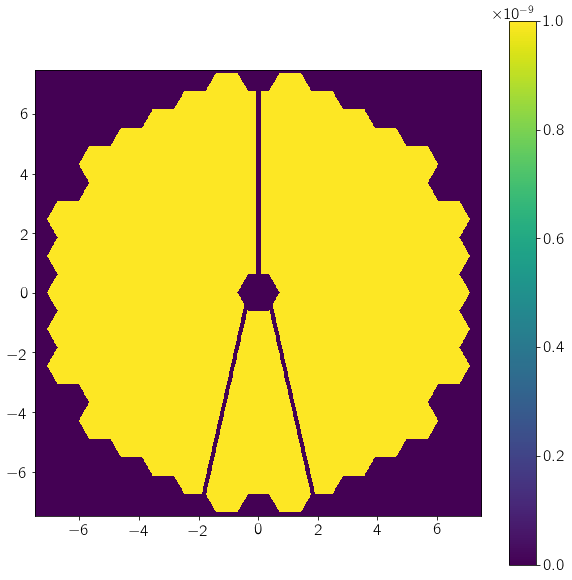

In [85]:
LO_modes = np.zeros(n_LO)
MID_modes = np.zeros(n_MID)
HI_modes = np.zeros(n_HI)
DM_modes = np.zeros(n_DM)
luvoir.zm.actuators = LO_modes
luvoir.sm.actuators = MID_modes
luvoir.fm.actuators = HI_modes
luvoir.dm.actuators = DM_modes
input_wf = luvoir.wf_aper
LO_modes[0] = eunit / 2
luvoir.zm.actuators  = LO_modes
tmp_pupil = luvoir.zm(input_wf)
plt.figure(figsize=(10, 10))
hc.imshow_field(tmp_pupil.phase/tmp_pupil.wavenumber)
plt.colorbar()

# Make matrices

In [79]:
mat_LO = np.zeros([n_LO-1, n_LO-1])
for i in range(1, n_LO):
    for j in range(1, n_LO):
        tmpI = G_LO_real[i]+1j*G_LO_imag[i] - Efield_ref
        tmpJ = G_LO_real[j]+1j*G_LO_imag[j] - Efield_ref
        test = np.real(tmpI*np.conj(tmpJ))
        dh_test = (test / norm) * dh_mask
        contrast = np.mean(dh_test[np.where(dh_mask != 0)])
        mat_LO[i-1, j-1] = contrast        

In [80]:
mat_MID = np.zeros([n_MID, n_MID])
for i in range(0, n_MID):
    for j in range(0, n_MID):
        tmpI = G_MID_real[i]+1j*G_MID_imag[i] - Efield_ref
        tmpJ = G_MID_real[j]+1j*G_MID_imag[j] - Efield_ref
        test = np.real(tmpI*np.conj(tmpJ))
        dh_test = (test / norm) * dh_mask
        contrast = np.mean(dh_test[np.where(dh_mask != 0)])
        mat_MID[i, j] = contrast    

In [81]:
mat_HI = np.zeros([n_HI, n_HI])
for i in range(0, n_HI):
    for j in range(0, n_HI):
        tmpI = G_HI_real[i]+1j*G_HI_imag[i] - Efield_ref
        tmpJ = G_HI_real[j]+1j*G_HI_imag[j] - Efield_ref
        test = np.real(tmpI*np.conj(tmpJ))
        dh_test = (test / norm) * dh_mask
        contrast = np.mean(dh_test[np.where(dh_mask != 0)])
        mat_HI[i, j] = contrast    

## Read eigenmodes and eigenvalues

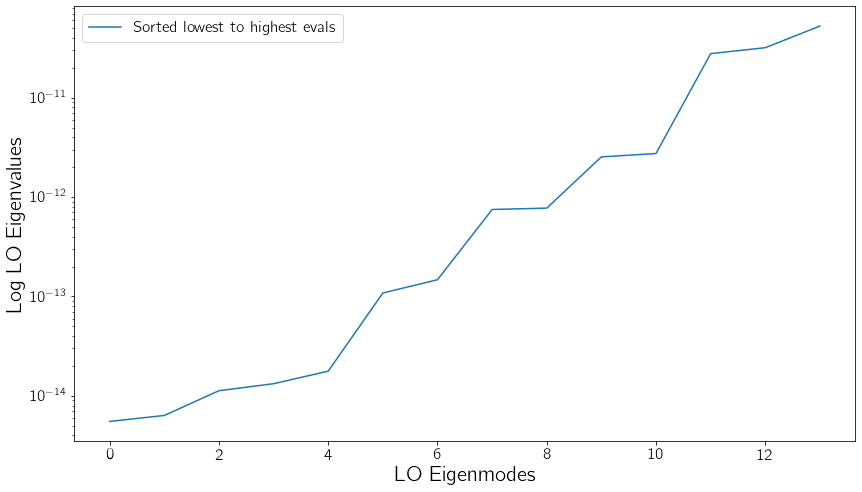

In [90]:
evalsLO, evecsLO = np.linalg.eig(mat_LO)
sorted_evalsLO = np.sort(evalsLO)
sorted_indicesLO = np.argsort(evalsLO)
sorted_evecsLO = evecsLO[:, sorted_indicesLO]
plt.figure(figsize=(14, 8))
#plt.plot(evals, label='Unsorted from eigendecomposition')
plt.plot(sorted_evalsLO, label='Sorted lowest to highest evals')
plt.semilogy()
plt.xlabel('LO Eigenmodes')
plt.ylabel('Log LO Eigenvalues')
plt.legend()

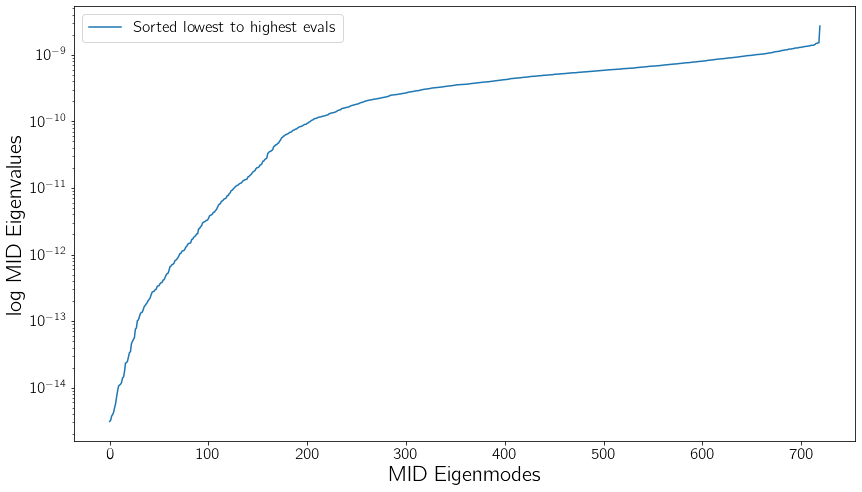

In [91]:
evalsMID, evecsMID = np.linalg.eig(mat_MID)
sorted_evalsMID = np.sort(evalsMID)
sorted_indicesMID = np.argsort(evalsMID)
sorted_evecsMID = evecsMID[:, sorted_indicesMID]
plt.figure(figsize=(14, 8))
#plt.pMIDt(evals, label='Unsorted from eigendecomposition')
plt.plot(sorted_evalsMID, label='Sorted lowest to highest evals')
plt.semilogy()
plt.xlabel('MID Eigenmodes')
plt.ylabel('log MID Eigenvalues')
plt.legend()

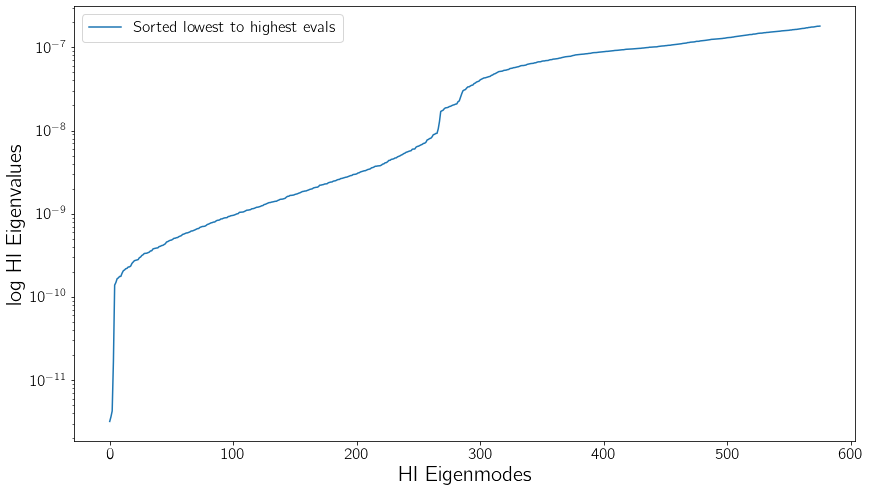

In [92]:
evalsHI, evecsHI = np.linalg.eig(mat_HI)
sorted_evalsHI = np.sort(evalsHI)
sorted_indicesHI = np.argsort(evalsHI)
sorted_evecsHI = evecsHI[:, sorted_indicesHI]
plt.figure(figsize=(14, 8))
#plt.pHIt(evals, label='Unsorted from eigendecomposition')
plt.plot(sorted_evalsHI, label='Sorted lowest to highest evals')
plt.semilogy()
plt.xlabel('HI Eigenmodes')
plt.ylabel('log HI Eigenvalues')
plt.legend()

# Check the 0 th and end modes

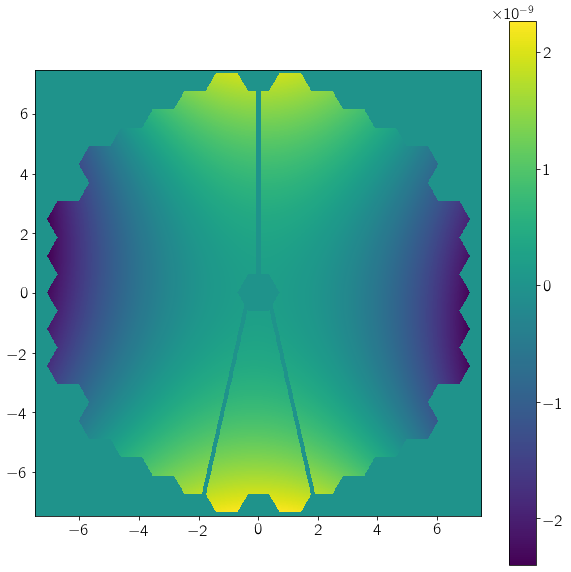

In [101]:
LO_modes = np.zeros(n_LO)
MID_modes = np.zeros(n_MID)
HI_modes = np.zeros(n_HI)
DM_modes = np.zeros(n_DM)
luvoir.zm.actuators = LO_modes
luvoir.sm.actuators = MID_modes
luvoir.fm.actuators = HI_modes
luvoir.dm.actuators = DM_modes
input_wf = luvoir.wf_aper
LO_modes[1:n_LO] = eunit / 2 *sorted_evecsLO[2,:]
luvoir.zm.actuators  = LO_modes
tmp_pupil = luvoir.zm(input_wf)
plt.figure(figsize=(10, 10))
hc.imshow_field(tmp_pupil.phase/tmp_pupil.wavenumber)
plt.colorbar()

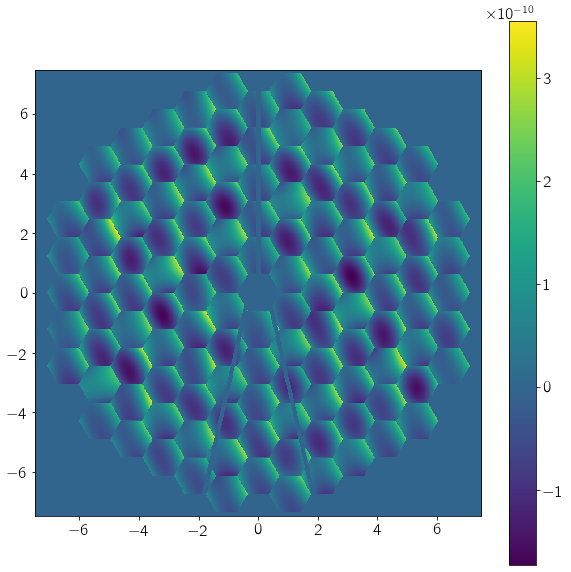

In [124]:
LO_modes = np.zeros(n_LO)
MID_modes = np.zeros(n_MID)
HI_modes = np.zeros(n_HI)
DM_modes = np.zeros(n_DM)
luvoir.zm.actuators = LO_modes
luvoir.sm.actuators = MID_modes
luvoir.fm.actuators = HI_modes
luvoir.dm.actuators = DM_modes
input_wf = luvoir.wf_aper
MID_modes = eunit / 2 *sorted_evecsMID[:,n_MID-1]
luvoir.sm.actuators  = MID_modes
tmp_pupil = luvoir.sm(input_wf)
plt.figure(figsize=(10, 10))
hc.imshow_field(tmp_pupil.phase/tmp_pupil.wavenumber)
plt.colorbar()

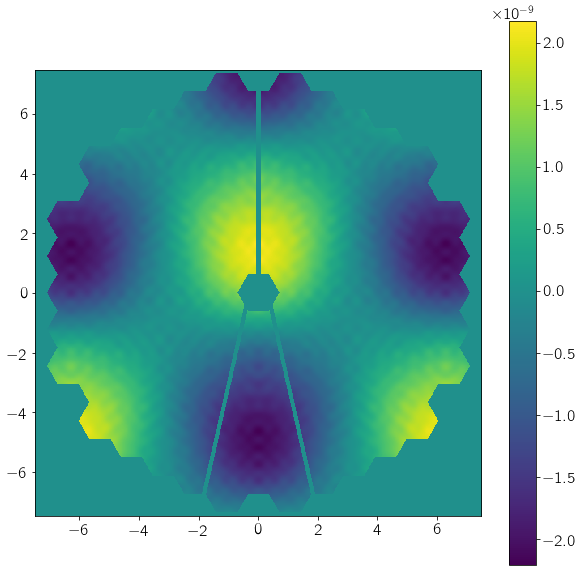

In [127]:
LO_modes = np.zeros(n_LO)
MID_modes = np.zeros(n_MID)
HI_modes = np.zeros(n_HI)
DM_modes = np.zeros(n_DM)
luvoir.zm.actuators = LO_modes
luvoir.sm.actuators = MID_modes
luvoir.fm.actuators = HI_modes
luvoir.dm.actuators = DM_modes
input_wf = luvoir.wf_aper
HI_modes = eunit / 2 *sorted_evecsHI[:,1]
luvoir.fm.actuators  = HI_modes
tmp_pupil = luvoir.fm(input_wf)
plt.figure(figsize=(10, 10))
hc.imshow_field(tmp_pupil.phase/tmp_pupil.wavenumber)
plt.colorbar()

In [42]:
# Calculate single sigma - remember that we start numbering at 0 because of python
def get_sigma(cstat, nseg, eigenval):
#     sigma = np.sqrt((cstat - c_zero) / ((nseg-1)*eigenval))
    sigma = np.sqrt((cstat) / ((nseg-1)*eigenval))

    return sigma

Text(0, 0.5, 'Max mode contribution $\\sigma_p$ (nm)')

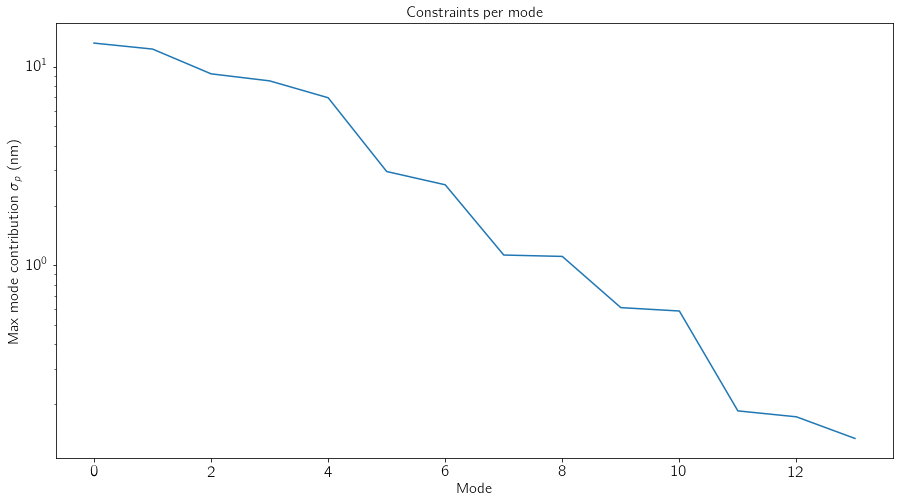

In [43]:
c_stat = 4e-11/3
sigmasLO = get_sigma(c_stat, n_LO, sorted_evalsLO)
plt.figure(figsize=(15, 8))
plt.plot(sigmasLO[1:])
plt.semilogy()
plt.title('Constraints per mode', size=15)
plt.xlabel('Mode', size=15)
plt.ylabel('Max mode contribution $\sigma_p$ (nm)', size=15)

Text(0, 0.5, 'Max mode contribution $\\sigma_p$ (nm)')

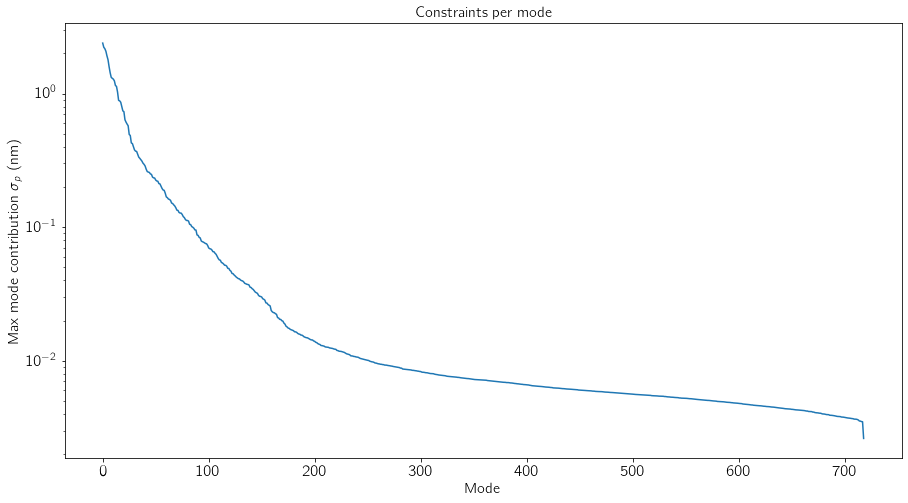

In [45]:
c_stat = 4e-11/3
sigmasMID = get_sigma(c_stat, n_MID, sorted_evalsMID)
plt.figure(figsize=(15, 8))
plt.plot(sigmasMID[1:])
plt.semilogy()
plt.title('Constraints per mode', size=15)
plt.xlabel('Mode', size=15)
plt.ylabel('Max mode contribution $\sigma_p$ (nm)', size=15)

Text(0, 0.5, 'Max mode contribution $\\sigma_p$ (nm)')

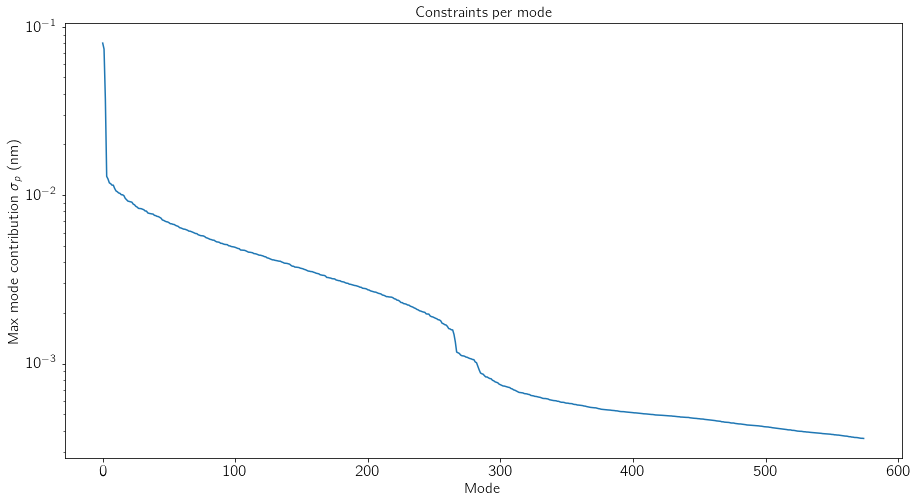

In [46]:
c_stat = 4e-11/3
sigmasHI = get_sigma(c_stat, n_HI, sorted_evalsHI)
plt.figure(figsize=(15, 8))
plt.plot(sigmasHI[1:])
plt.semilogy()
plt.title('Constraints per mode', size=15)
plt.xlabel('Mode', size=15)
plt.ylabel('Max mode contribution $\sigma_p$ (nm)', size=15)

In [128]:
c_dyn = 1e-11
# Calculate the Delta Cs
def get_delta_sigma(cdyn, nseg, eigenval):
    del_sigma = np.sqrt(cdyn / (np.sqrt(nseg-1)*eigenval))
    return del_sigma

In [ ]:
plt.figure(figsize=(15, 8))
plt.plot(del_sigmas[1:])
plt.semilogy()
plt.title('Stability per mode', size=15)
plt.xlabel('Mode', size=15)
plt.ylabel('Max mode contribution $\Delta \sigma_p$ (nm)', size=15)

So this part dos not work proprly yet. We need to check is a little more. I believe the problem is the raw contrast not being subtractd at the right place

## Segment based constraints

In [129]:
c_target = 4e-11/3

In [139]:
modestosegsLO = np.linalg.pinv(sorted_evecsLO)
modestosegsMID = np.linalg.pinv(sorted_evecsMID)
modestosegsHI = np.linalg.pinv(sorted_evecsHI)

# # Calculate all mean contrasts of the pastis modes directly (as-is, with natural normalization)
# c_avg = []
# for i in range(number_of_modes):
#     c_avg.append(util.pastis_contrast(sorted_evecs[:, i] * u.nm, matrix) + baseline_contrast)

# # Calculate segment requirements
# mu_map = np.sqrt(
#     ((c_target - baseline_contrast) / number_of_modes) / (np.dot(c_avg - baseline_contrast, np.square(modestosegs))))

# Calculate all mean contrasts of the pastis modes directly (as-is, with natural normalization)
c_avgLO = []
for i in range(n_LO-1):
    c_avgLO.append(util.pastis_contrast(sorted_evecsLO[:, i] * u.nm, mat_LO) )
    
c_avgMID = []
for i in range(n_MID):
    c_avgMID.append(util.pastis_contrast(sorted_evecsMID[:, i] * u.nm, mat_MID) )

c_avgHI = []
for i in range(n_HI):
    c_avgHI.append(util.pastis_contrast(sorted_evecsHI[:, i] * u.nm, mat_HI) )

# Calculate segment requirements
mu_mapLO = np.sqrt(
    ((c_target ) / (n_LO-1)) / (np.dot(c_avgLO, np.square(modestosegsLO))))
mu_mapMID = np.sqrt(
    ((c_target ) / (n_MID-1)) / (np.dot(c_avgMID, np.square(modestosegsMID))))
mu_mapHI = np.sqrt(
    ((c_target ) / (n_HI-1)) / (np.dot(c_avgHI, np.square(modestosegsHI))))
# c_avgLO = []
# for i in range(n_LO-1):
#     c_avgLO.append(util.pastis_contrast(sorted_evecsLO[:, i] * u.nm, mat_LO) )

In [832]:
N_zernike = max_MID
zernike_coeffs_numaps = np.zeros([N_zernike,n_MID])
for qq in range(N_zernike):
    zernike_coeffs_tmp = np.zeros([n_MID])
    for pp in range(120):
        zernike_coeffs_tmp[qq+(pp)*N_zernike] = mu_mapMID[qq+(pp)*N_zernike]
    zernike_coeffs_numaps[qq] = zernike_coeffs_tmp
nu_maps = []
for qq in range(N_zernike):
    zernike_coeffs = eunit*zernike_coeffs_numaps[qq]/2
    luvoir.sm.actuators = zernike_coeffs
    nu_maps.append(luvoir.sm(luvoir.wf_aper).phase/luvoir.wf_aper.wavenumber)

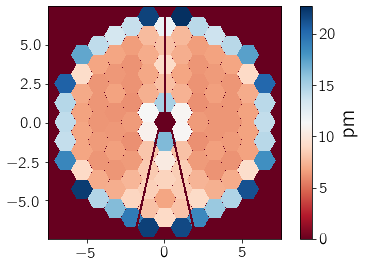

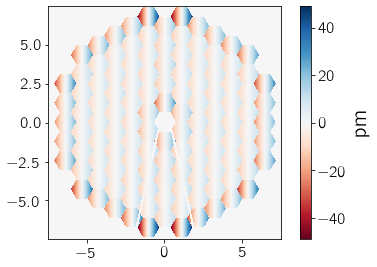

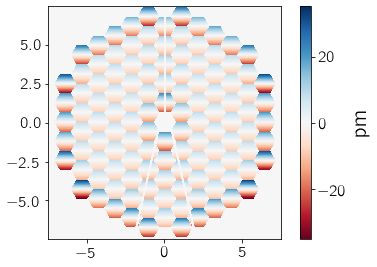

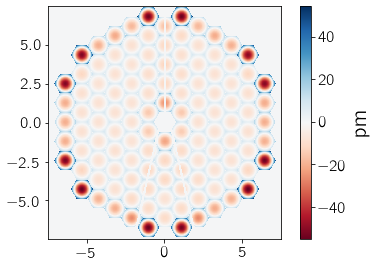

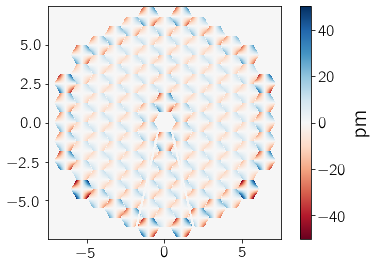

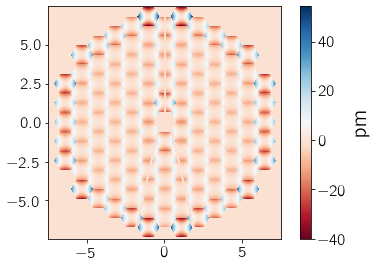

In [835]:
for pp in range(0,max_MID):
    fig, ax = plt.subplots(ncols=1)
    img1 = hc.imshow_field(nu_maps[pp]/eunit*1000, cmap='RdBu')#, vmin=pmin, vmax=pmax)
    clb = fig.colorbar(img1)
    clb.set_label('pm', rotation=90)
    plt.tight_layout(h_pad=1)

# Check the normalization of each poked mode

In [219]:
LO_mode_rms_v1 = np.zeros(n_LO-1)
LO_mode_rms_v2 = np.zeros(n_LO-1)
contrast_check_LO = np.zeros(n_LO-1)
for pp in range(1,n_LO):
#     print(pp)
    LO_modes = np.zeros(n_LO)
    MID_modes = np.zeros(n_MID)
    HI_modes = np.zeros(n_HI)
    DM_modes = np.zeros(n_DM)
    luvoir.zm.actuators = LO_modes
    luvoir.sm.actuators = MID_modes
    luvoir.fm.actuators = HI_modes
    luvoir.dm.actuators = DM_modes
    input_wf = luvoir.wf_aper
    LO_modes[pp] = eunit / 2
    luvoir.zm.actuators  = LO_modes
    tmp_pupil = luvoir.zm(input_wf)
    wavefront_map_tmp = tmp_pupil.phase/tmp_pupil.wavenumber*luvoir.aper
    LO_mode_rms_v1[pp-1] = np.sqrt(np.sum(wavefront_map_tmp**2)/np.sum(luvoir.aper))
    wavefront_map_tmp = luvoir.zm.opd*luvoir.aper
    LO_mode_rms_v2[pp-1] = np.sqrt(np.sum(wavefront_map_tmp**2)/np.sum(luvoir.aper))
    psf, ref = luvoir.calc_psf(ref=True, return_intermediate='False')
    dh_intensity = psf/norm * dh_mask
    test_contrast = np.mean(dh_intensity[np.where(dh_intensity != 0)]) - contrast_floor
    contrast_check_LO[pp-1] = test_contrast

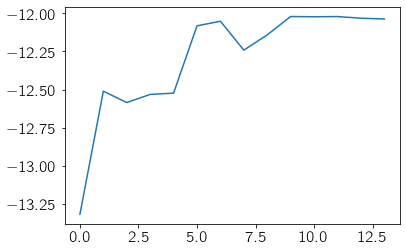

In [241]:
plt.plot(np.log10(np.abs(mu_mapLO**2*contrast_check_LO)))

In [245]:
np.sum(mu_mapLO**2*contrast_check_LO)

8.216937270854244e-12

In [226]:
MID_mode_rms_v1 = np.zeros(n_MID)
MID_mode_rms_v2 = np.zeros(n_MID)
contrast_check_MID = np.zeros(n_MID)
seg_counter = 0
for pp in range(0,n_MID):
    current_seg = seg_evaluated[seg_counter]
    LO_modes = np.zeros(n_LO)
    MID_modes = np.zeros(n_MID)
    HI_modes = np.zeros(n_HI)
    DM_modes = np.zeros(n_DM)
    luvoir.zm.actuators = LO_modes
    luvoir.sm.actuators = MID_modes
    luvoir.fm.actuators = HI_modes
    luvoir.dm.actuators = DM_modes
    input_wf = luvoir.wf_aper
    MID_modes[pp] = eunit / 2
    luvoir.sm.actuators  = MID_modes
    tmp_pupil = luvoir.sm(input_wf)
    wavefront_map_tmp = tmp_pupil.phase/tmp_pupil.wavenumber*current_seg
    MID_mode_rms_v1[pp] = np.sqrt(np.sum(wavefront_map_tmp**2)/np.sum(current_seg))
    wavefront_map_tmp = luvoir.sm.opd*current_seg
    MID_mode_rms_v2[pp] = np.sqrt(np.sum(wavefront_map_tmp**2)/np.sum(current_seg))
    psf, ref = luvoir.calc_psf(ref=True, return_intermediate='False')
    dh_intensity = psf/norm * dh_mask
    test_contrast = np.mean(dh_intensity[np.where(dh_intensity != 0)]) - contrast_floor
    contrast_check_MID[pp] = test_contrast
    if np.remainder(pp,max_MID) == max_MID - 1:
        seg_counter = seg_counter + 1

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [242]:
np.sum(mu_mapMID**2*contrast_check_MID)

1.3161850818138415e-11

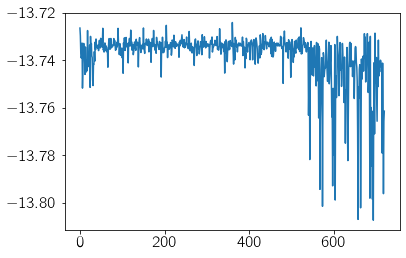

In [239]:
plt.plot(np.log10(np.abs(mu_mapMID**2*contrast_check_MID)))

In [234]:
HI_mode_rms_v1 = np.zeros(n_HI)
HI_mode_rms_v2 = np.zeros(n_HI)
contrast_check_HI = np.zeros(n_HI)
seg_counter = 0
for pp in range(0,n_HI):
    current_seg = seg_evaluated[seg_counter]
    LO_modes = np.zeros(n_LO)
    MID_modes = np.zeros(n_MID)
    HI_modes = np.zeros(n_HI)
    DM_modes = np.zeros(n_DM)
    luvoir.zm.actuators = LO_modes
    luvoir.sm.actuators = MID_modes
    luvoir.fm.actuators = HI_modes
    luvoir.dm.actuators = DM_modes
    input_wf = luvoir.wf_aper
    HI_modes[pp] = eunit / 2
    luvoir.fm.actuators  = HI_modes
    tmp_pupil = luvoir.fm(input_wf)
    wavefront_map_tmp = tmp_pupil.phase/tmp_pupil.wavenumber*luvoir.aper
    HI_mode_rms_v1[pp] = np.sqrt(np.sum(wavefront_map_tmp**2)/np.sum(luvoir.aper))
    wavefront_map_tmp = luvoir.fm.opd*luvoir.aper
    HI_mode_rms_v2[pp] = np.sqrt(np.sum(wavefront_map_tmp**2)/np.sum(luvoir.aper))
    psf, ref = luvoir.calc_psf(ref=True, return_intermediate='False')
    dh_intensity = psf/norm * dh_mask
    test_contrast = np.mean(dh_intensity[np.where(dh_intensity != 0)]) - contrast_floor
    contrast_check_HI[pp] = test_contrast

In [244]:
np.sum(mu_mapHI**2*contrast_check_HI)

1.3100835437740548e-11

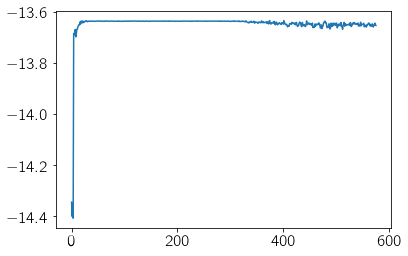

In [238]:
plt.plot(np.log10(np.abs(mu_mapHI**2*contrast_check_HI)))

In [ ]:
# fig, ax = plt.subplots(ncols=1)
# img1 = hc.imshow_field(nu_maps[0]/eunit*1000, cmap='RdBu')#, vmin=pmin, vmax=pmax)
# clb = fig.colorbar(img1)
# clb.set_label('pm', rotation=90)
# plt.tight_layout(h_pad=1)
# plt.title('Segment Level Piston ')
# zernike_coeffs = zernike_coeffs_numaps[0]*eunit/2
# luvoir.sm.actuators = zernike_coeffs
# luvoir.sm(luvoir.wf_aper)
# psf, ref = luvoir.calc_psf(ref=True, return_intermediate='False')
# plt.figure(figsize=(10, 10))
# hc.imshow_field(psf/norm, norm=LogNorm())
# plt.colorbar()
# dh_intensity = psf/norm * dh_mask
# test_contrast = np.mean(dh_intensity[np.where(dh_intensity != 0)])- baseline_contrast
# print('contrast:', test_contrast)

# Calculaing the requieremnt with Leonid's method

In [870]:
# From Neill Z calculation
fudge_core = 2 # not exactly right hence the fudge, debug with full aperture
Nph = fudge_core*2.052e09*luvoir.wvln/eunit*0.1

In [871]:
LO_modes = np.zeros(n_LO)
MID_modes = np.zeros(n_MID)
HI_modes = np.zeros(n_HI)
DM_modes = np.zeros(n_DM)
luvoir.zm.actuators = LO_modes
luvoir.sm.actuators = MID_modes
luvoir.fm.actuators = HI_modes
luvoir.dm.actuators = DM_modes
unaberrated_coro_psf, ref = luvoir.calc_psf(ref=True, display_intermediate=False, return_intermediate=False)
norm = np.max(ref)
#the normalization is not perfect yet

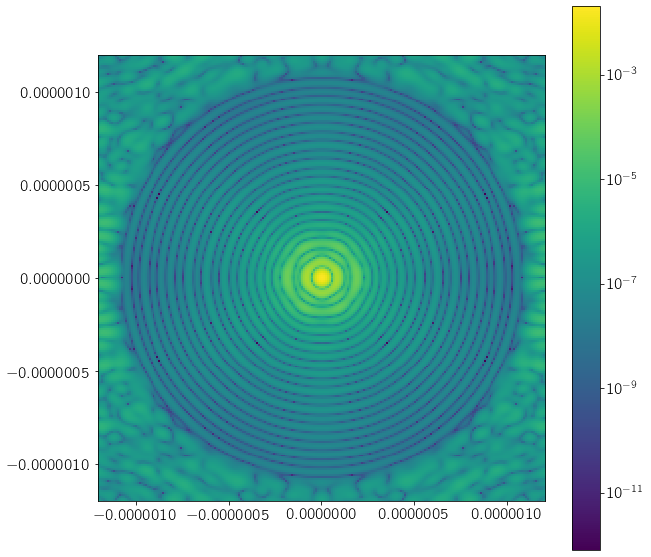

In [878]:
plt.figure(figsize=(10, 10))
hc.imshow_field(ref, norm=LogNorm())
plt.colorbar()

In [875]:
core = hc.circular_aperture(2 * 0.7 * luvoir.lam_over_d)(luvoir.focal_det)
core_mask = (core).astype('bool')

In [879]:
np.sum(np.abs(ref))

Field(0.58200529)

In [880]:
np.sum(np.abs(core_mask*ref)) #so that is a factor of two

Field(0.29402903)

In [882]:
fudge_fluxes = z_pup_downsample

In [883]:
LO_modes = np.zeros(n_LO)
MID_modes = np.zeros(n_MID)
HI_modes = np.zeros(n_HI)
DM_modes = np.zeros(n_DM)
luvoir.zm.actuators = LO_modes
luvoir.sm.actuators = MID_modes
luvoir.fm.actuators = HI_modes
luvoir.dm.actuators = DM_modes

nonaberrated_coro_psf, ref,inter_ref = luvoir.calc_psf(ref=True, display_intermediate=False, return_intermediate='efield')
Efield_ref = inter_ref['at_science_focus'].electric_field

zernike_ref = luvoir.prop_LOWFS()
zernike_ref_sub_real = hc.field.subsample_field(zernike_ref.real, z_pup_downsample, grid_zernike, statistic='mean')
zernike_ref_sub_imag = hc.field.subsample_field(zernike_ref.imag, z_pup_downsample, grid_zernike, statistic='mean')
Efield_ref_LOWFS = (zernike_ref_sub_real + 1j*zernike_ref_sub_imag)*z_pup_downsample

zernike_ref = luvoir.prop_OBWFS()
zernike_ref_sub_real = hc.field.subsample_field(zernike_ref.real, z_pup_downsample, grid_zernike, statistic='mean')
zernike_ref_sub_imag = hc.field.subsample_field(zernike_ref.imag, z_pup_downsample, grid_zernike, statistic='mean')
Efield_ref_OBWFS = (zernike_ref_sub_real + 1j*zernike_ref_sub_imag)*z_pup_downsample

In [884]:
# plt.figure(figsize=(10, 10))
# hc.imshow_field(Efield_ref_LOWFS.imag)
# plt.colorbar()
# plt.figure(figsize=(10, 10))
# hc.imshow_field(Efield_ref_LOWFS.real)
# plt.colorbar()
# plt.figure(figsize=(10, 10))
# hc.imshow_field(Efield_ref.real)
# plt.colorbar()
# plt.figure(figsize=(10, 10))
# hc.imshow_field(Efield_ref.imag)
# plt.colorbar()

In [885]:
# plt.figure(figsize=(10, 10))
# plt.imshow(np.reshape(G_coron_LO[:,0,0],[227,227]))
# plt.colorbar()
# plt.figure(figsize=(10, 10))
# plt.imshow(np.reshape(G_coron_LO[:,1,0],[227,227]))
# plt.colorbar()
# plt.figure(figsize=(10, 10))
# plt.imshow(np.reshape(G_LOWFS[:,0,0],[100,100]))
# plt.colorbar()
# plt.figure(figsize=(10, 10))
# plt.imshow(np.reshape(G_LOWFS[:,1,0],[100,100]))
# plt.colorbar()

In [985]:
dh_size = len(np.where(dh_mask != 0)[0])
dh_index = np.where(dh_mask != 0)[0]

In [989]:
E0_LOWFS = np.zeros([N_pup_z*N_pup_z,1,2])
E0_LOWFS[:,0,0] = Efield_ref_LOWFS.real
E0_LOWFS[:,0,1] = Efield_ref_LOWFS.imag
E0_OBWFS = np.zeros([N_pup_z*N_pup_z,1,2])
E0_OBWFS[:,0,0] = Efield_ref_OBWFS.real
E0_OBWFS[:,0,1] = Efield_ref_OBWFS.imag
E0_coron = np.zeros([n_img*n_img,1,2])
E0_coron[:,0,0] = Efield_ref.real
E0_coron[:,0,1] = Efield_ref.imag
E0_coron_DH = np.zeros([dh_size,1,2])
E0_coron_DH[:,0,0] = Efield_ref.real[dh_index]
E0_coron_DH[:,0,1] = Efield_ref.imag[dh_index]

In [950]:
n_img = np.int(np.sqrt(Efield_ref.shape))
G_coron_LO_DH = np.zeros([dh_size,2,n_LO-1])
for pp in range(1,n_LO):
    G_coron_LO_DH[:,0,pp-1] = G_LO_real[pp,dh_index] - Efield_ref.real[dh_index]
    G_coron_LO_DH[:,1,pp-1] = G_LO_imag[pp,dh_index] - Efield_ref.imag[dh_index]
G_coron_MID_DH= np.zeros([dh_size,2,n_MID])
for pp in range(0,n_MID):
    G_coron_MID_DH[:,0,pp] = G_MID_real[pp,dh_index] - Efield_ref.real[dh_index]
    G_coron_MID_DH[:,1,pp] = G_MID_imag[pp,dh_index] - Efield_ref.imag[dh_index]
G_coron_HI_DH= np.zeros([dh_size,2,n_HI])
for pp in range(0,n_HI):
    G_coron_HI_DH[:,0,pp] = G_HI_real[pp,dh_index] - Efield_ref.real[dh_index]
    G_coron_HI_DH[:,1,pp] = G_HI_imag[pp,dh_index] - Efield_ref.imag[dh_index]

In [952]:
n_img = np.int(np.sqrt(Efield_ref.shape))
G_coron_LO = np.zeros([n_img*n_img,2,n_LO-1])
for pp in range(1,n_LO):
    G_coron_LO[:,0,pp-1] = G_LO_real[pp] - Efield_ref.real
    G_coron_LO[:,1,pp-1] = G_LO_imag[pp] - Efield_ref.imag
G_coron_MID= np.zeros([n_img*n_img,2,n_MID])
for pp in range(0,n_MID):
    G_coron_MID[:,0,pp] = G_MID_real[pp] - Efield_ref.real
    G_coron_MID[:,1,pp] = G_MID_imag[pp] - Efield_ref.imag
G_coron_HI= np.zeros([n_img*n_img,2,n_HI])
for pp in range(0,n_HI):
    G_coron_HI[:,0,pp] = G_HI_real[pp] - Efield_ref.real
    G_coron_HI[:,1,pp] = G_HI_imag[pp] - Efield_ref.imag

In [953]:
G_LOWFS = np.zeros([N_pup_z*N_pup_z,2,n_LO-1])
for pp in range(1,n_LO):
    G_LOWFS[:,0,pp-1] = G_LOWFS_real[pp]*z_pup_downsample - Efield_ref_LOWFS.real
    G_LOWFS[:,1,pp-1] = G_LOWFS_imag[pp]*z_pup_downsample - Efield_ref_LOWFS.imag
G_OBWFS= np.zeros([N_pup_z*N_pup_z,2,n_MID])
for pp in range(0,n_MID):
    G_OBWFS[:,0,pp] = G_OBWFS_real[pp]*z_pup_downsample - Efield_ref_OBWFS.real
    G_OBWFS[:,1,pp] = G_OBWFS_imag[pp]*z_pup_downsample - Efield_ref_OBWFS.imag

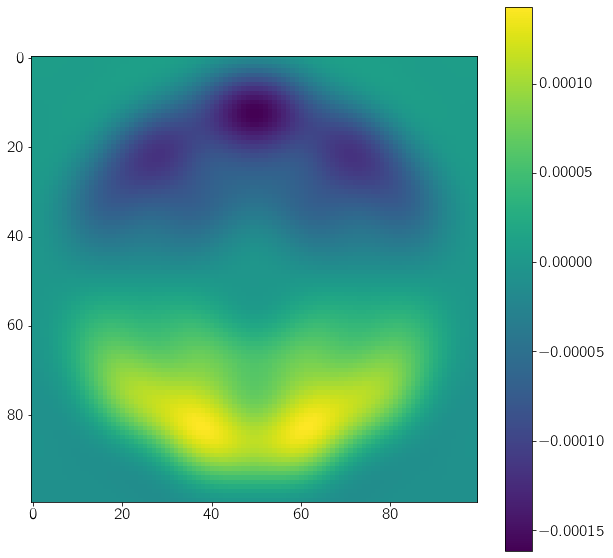

In [954]:
plt.figure(figsize=(10, 10))
plt.imshow(np.reshape(G_LOWFS[:,1,1],[100,100]))
plt.colorbar()

In [965]:
G_coron_HI.shape

(51529, 2, 576)

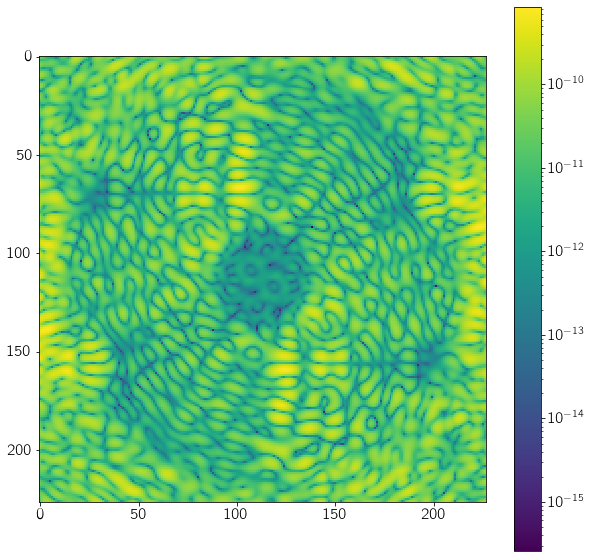

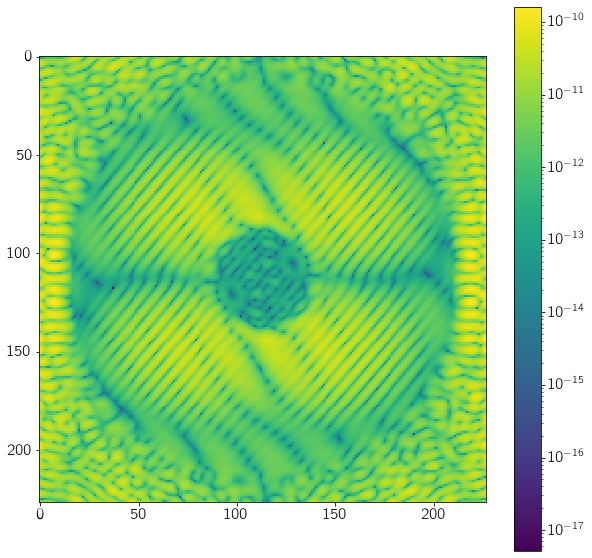

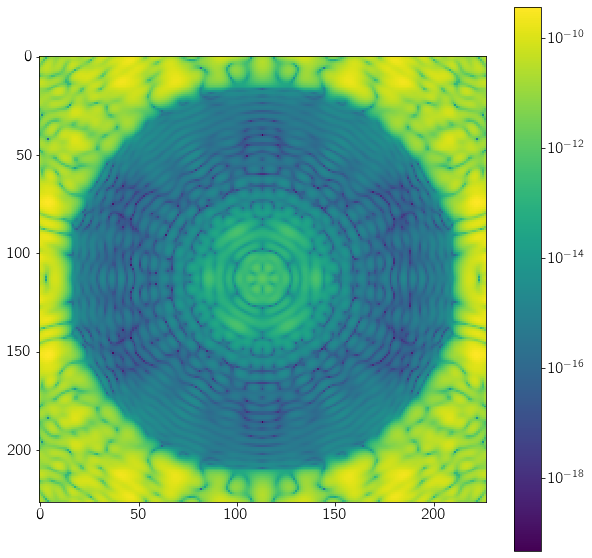

In [967]:
plt.figure(figsize=(10, 10))
plt.imshow(np.reshape(G_coron_HI[:,1,400]**2+G_coron_HI[:,0,2]**2,[227,227]),norm=LogNorm())
plt.colorbar()
plt.figure(figsize=(10, 10))
plt.imshow(np.reshape(G_coron_MID[:,1,400]**2+G_coron_MID[:,0,2]**2,[227,227]),norm=LogNorm())
plt.colorbar()
plt.figure(figsize=(10, 10))
plt.imshow(np.reshape(G_coron_LO[:,1,8]**2+G_coron_LO[:,0,2]**2,[227,227]),norm=LogNorm())
plt.colorbar()

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(np.reshape(G_OBWFS[:,1,2],[100,100]))
plt.colorbar()

In [891]:
# N = 100*100
# N_img = n_img*n_img
# # Q = np.eye(r)
# fudge_std = 0.03
# Q =  np.diag((mu_map*fudge_std)**2)
# c = 1
# t_exp = 60
# flux = Nph/100
# # D = Nph/1e9
# D = 0
# P = Q*0.0

In [968]:
def req_closedloop_calc_recursive(Gcoro,Gsensor,E0coro,E0sensor,Dcoro,Dsensor,t_exp,flux,Q,Niter):
    
    P = np.zeros(Q.shape)#WFE modes covariance estimate
    r = Gsensor.shape[2]
    N = Gsensor.shape[0]
    N_img = Gcoro.shape[0]
    c = 1
    #Iterations of ALGORITHM 1
    contrast_hist = np.zeros(Niter)
    intensity_WFS_hist = np.zeros(Niter)
    cal_I_hist = np.zeros(Niter)
    eps_hist = np.zeros([Niter,r])
    averaged_hist = np.zeros(Niter) 
    contrasts = []
    for pp in range(Niter):
        eps = np.random.multivariate_normal(np.zeros(r), P+Q*t_exp).reshape((1,1,r)) #random modes
        G_eps = np.sum(Gsensor*eps, axis=2).reshape((N,1,2*c)) + E0sensor #electric field
        G_eps_squared = np.sum(G_eps*G_eps, axis=2, keepdims=True)
        G_eps_G = np.matmul(G_eps, Gsensor)
        G_eps_G_scaled = G_eps_G/np.sqrt(G_eps_squared + Dsensor/flux/t_exp) #trick to save RAM
        cal_I = 4*flux*t_exp*np.einsum("ijk,ijl->kl", G_eps_G_scaled, G_eps_G_scaled) #information matrix
        P = np.linalg.inv(np.linalg.inv(P+Q*t_exp/2) + cal_I)
#         P = np.linalg.inv(cal_I)

    #Coronagraph
        G_eps_coron = np.sum(Gcoro*eps, axis=2).reshape((N_img,1,2*c)) + E0coro
        G_eps_coron_squared = np.sum(G_eps_coron*G_eps_coron, axis=2, keepdims=True)
        intensity = G_eps_coron_squared*flux*t_exp + Dcoro

    # Wavefront sensor
        intensity_WFS = G_eps_squared*flux*t_exp + Dsensor

    # Archive
        test_DH0 = intensity[:,0,0]*dh_mask
        test_DH = np.mean(test_DH0[np.where(test_DH0 != 0)])
        contrasts.append(test_DH/flux/t_exp/norm)
        intensity_WFS_hist[pp] = np.sum(intensity_WFS)/flux
        cal_I_hist[pp] = np.mean(cal_I)/flux
        eps_hist[pp] = eps
        averaged_hist[pp] = np.mean(contrasts)
        print("est. contrast", np.mean(contrasts))

        
        outputs = {'intensity_WFS_hist': intensity_WFS_hist,
                             'cal_I_hist': cal_I_hist,
                             'eps_hist': eps_hist,
                             'averaged_hist': averaged_hist,
                             'contrasts': contrasts}
    return outputs

In [969]:
def req_closedloop_calc_batch(Gcoro,Gsensor,E0coro,E0sensor,Dcoro,Dsensor,t_exp,flux,Q,Niter):
    
    P = np.zeros(Q.shape)#WFE modes covariance estimate
    r = Gsensor.shape[2]
    N = Gsensor.shape[0]
    N_img = Gcoro.shape[0]
    c = 1
    #Iterations of ALGORITHM 1
    contrast_hist = np.zeros(Niter)
    intensity_WFS_hist = np.zeros(Niter)
    cal_I_hist = np.zeros(Niter)
    eps_hist = np.zeros([Niter,r])
    averaged_hist = np.zeros(Niter) 
    contrasts = []
    for pp in range(Niter):
        eps = np.random.multivariate_normal(np.zeros(r), P+Q*t_exp).reshape((1,1,r)) #random modes
        G_eps = np.sum(Gsensor*eps, axis=2).reshape((N,1,2*c)) + E0sensor #electric field
        G_eps_squared = np.sum(G_eps*G_eps, axis=2, keepdims=True)
        G_eps_G = np.matmul(G_eps, Gsensor)
        G_eps_G_scaled = G_eps_G/np.sqrt(G_eps_squared + Dsensor/flux/t_exp) #trick to save RAM
        cal_I = 4*flux*t_exp*np.einsum("ijk,ijl->kl", G_eps_G_scaled, G_eps_G_scaled) #information matrix
#         P = np.linalg.inv(np.linalg.inv(P+Q*t_exp/2) + cal_I)
        P = np.linalg.inv(cal_I)

    #Coronagraph
        G_eps_coron = np.sum(Gcoro*eps, axis=2).reshape((N_img,1,2*c)) + E0coro
        G_eps_coron_squared = np.sum(G_eps_coron*G_eps_coron, axis=2, keepdims=True)
        intensity = G_eps_coron_squared*flux*t_exp + Dcoro

    # Wavefront sensor
        intensity_WFS = G_eps_squared*flux*t_exp + Dsensor

    # Archive
        test_DH0 = intensity[:,0,0]*dh_mask
        test_DH = np.mean(test_DH0[np.where(test_DH0 != 0)])
        contrasts.append(test_DH/flux/t_exp/norm)
        intensity_WFS_hist[pp] = np.sum(intensity_WFS)/flux
        cal_I_hist[pp] = np.mean(cal_I)/flux
        eps_hist[pp] = eps
        averaged_hist[pp] = np.mean(contrasts)
#         print("est. contrast", np.mean(contrasts))
        print("est. contrast", np.mean(contrasts))
        
    outputs = {'intensity_WFS_hist': intensity_WFS_hist,
                         'cal_I_hist': cal_I_hist,
                         'eps_hist': eps_hist,
                         'averaged_hist': averaged_hist,
                         'contrasts': contrasts}
        
    return outputs

In [970]:
QLO = np.diag(np.asarray(mu_mapLO**2))
QMID = np.diag(np.asarray(mu_mapMID**2))
QHI = np.diag(np.asarray(mu_mapHI**2))
flux = Nph

# LO Modes

LO batch, LOWFS

est. contrast 4.765164910346552e-11
est. contrast 4.641983767915735e-11
est. contrast 4.903300128433841e-11
est. contrast 4.7422305102233555e-11
est. contrast 4.850568522088834e-11
est. contrast 4.818672107317403e-11
est. contrast 4.960942234798441e-11
est. contrast 4.935735981299911e-11
est. contrast 4.934734834144897e-11
est. contrast 4.8735679195235535e-11
est. contrast 4.809275171933293e-11
est. contrast 4.8412267363160065e-11
est. contrast 4.929606861344762e-11
est. contrast 4.907371006012242e-11
est. contrast 4.894693035546989e-11
est. contrast 4.909550327206847e-11
est. contrast 4.920643633607468e-11
est. contrast 4.907333720936508e-11
est. contrast 4.9127276049419344e-11
est. contrast 4.898960397950468e-11
est. contrast 4.884634562191445e-11
est. contrast 4.942545111834159e-11
est. contrast 5.001143727337667e-11
est. contrast 5.020199504144937e-11
est. contrast 5.0371262337784684e-11
est. contrast 5.033602779505785e-11
est. contrast 5.045089959844753e-11
est. contrast 5.0288808

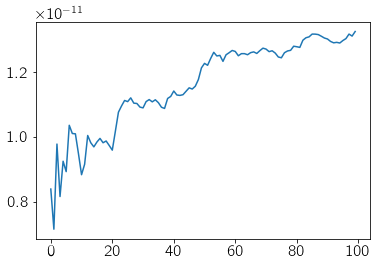

In [999]:
tscale = 0.01
wavescale = 10.
test = req_closedloop_calc_batch(G_coron_LO,G_LOWFS,E0_coron,E0_LOWFS,0,0,tscale,flux/100,wavescale**2*QLO,100)
he = test['averaged_hist']
plt.plot(he -contrast_floor)

LO batch, DH

est. contrast 4.219535681864789e-11
est. contrast 4.5574103085538205e-11
est. contrast 4.483954478671611e-11
est. contrast 4.522361819541655e-11
est. contrast 4.541450407572951e-11
est. contrast 4.532615950305323e-11
est. contrast 4.521102014755934e-11
est. contrast 4.520714474100413e-11
est. contrast 4.567345580477254e-11
est. contrast 4.5948295431345245e-11
est. contrast 4.709183239473841e-11
est. contrast 4.7460474657618086e-11
est. contrast 4.733198731159472e-11
est. contrast 4.69917302924638e-11
est. contrast 4.729423188717843e-11
est. contrast 4.7462746739714294e-11
est. contrast 4.733002495229069e-11
est. contrast 4.7531841564460223e-11
est. contrast 4.763890357297838e-11
est. contrast 4.760858809448976e-11
est. contrast 4.766456593757398e-11
est. contrast 4.822634689949089e-11
est. contrast 4.836532459701989e-11
est. contrast 4.8412485905761165e-11
est. contrast 4.817142770623656e-11
est. contrast 4.8498941088042736e-11
est. contrast 4.838036820610778e-11
est. contrast 4.824201

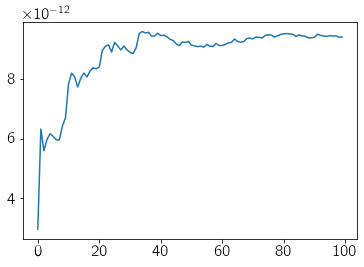

In [1002]:
tscale = 1
wavescale = 0.5
test = req_closedloop_calc_batch(G_coron_LO,G_coron_LO_DH,E0_coron,E0_coron_DH,0,0,tscale,flux/100,wavescale**2*QLO,100)
he = test['averaged_hist']
plt.plot(he -contrast_floor)

LO recursive, LOWFS

est. contrast 4.5168710764819255e-11
est. contrast 4.925033548351984e-11
est. contrast 4.870897274875983e-11
est. contrast 5.0221704399980436e-11
est. contrast 5.068082365296011e-11
est. contrast 5.200723054362734e-11
est. contrast 5.1256658475395344e-11
est. contrast 5.062829714767052e-11
est. contrast 5.0088745535729305e-11
est. contrast 5.155776737873438e-11
est. contrast 5.266721634202716e-11
est. contrast 5.227260254921234e-11
est. contrast 5.176922913862742e-11
est. contrast 5.148301701675463e-11
est. contrast 5.209409502154112e-11
est. contrast 5.2159985642995803e-11
est. contrast 5.190021139534643e-11
est. contrast 5.198541759457994e-11
est. contrast 5.184294879844436e-11
est. contrast 5.172665313735042e-11
est. contrast 5.1549005152967176e-11
est. contrast 5.132458171077322e-11
est. contrast 5.1266799314161873e-11
est. contrast 5.128440270861699e-11
est. contrast 5.1220501560312014e-11
est. contrast 5.145678133475544e-11
est. contrast 5.146477490429267e-11
est. contrast 5.1950

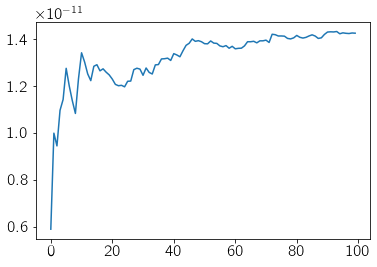

In [1003]:
tscale = 0.001
wavescale = 30.
test = req_closedloop_calc_recursive(G_coron_LO,G_LOWFS,E0_coron,E0_LOWFS,0,0,tscale,flux/100,wavescale**2*QLO,100)
he = test['averaged_hist']
plt.plot(he -contrast_floor)

LO recursive, DH

est. contrast 4.0453122882606495e-11
est. contrast 4.073815593626519e-11
est. contrast 4.0469279929997406e-11
est. contrast 4.0479932457604494e-11
est. contrast 4.083879690892349e-11
est. contrast 4.1119537748582266e-11
est. contrast 4.132656331360624e-11
est. contrast 4.1603422661023836e-11
est. contrast 4.18307816165274e-11
est. contrast 4.206180462256085e-11
est. contrast 4.229291406144045e-11
est. contrast 4.273162968576553e-11
est. contrast 4.277644498186779e-11
est. contrast 4.327203623119338e-11
est. contrast 4.3594411047117056e-11
est. contrast 4.397256282584889e-11
est. contrast 4.4226201561583545e-11
est. contrast 4.407086723936766e-11
est. contrast 4.3967402234537244e-11
est. contrast 4.396870161795231e-11
est. contrast 4.412705384999132e-11
est. contrast 4.4062454527901086e-11
est. contrast 4.4358561246157905e-11
est. contrast 4.45985659866515e-11
est. contrast 4.456577852487508e-11
est. contrast 4.459422726754968e-11
est. contrast 4.456293185436396e-11
est. contrast 4.4645

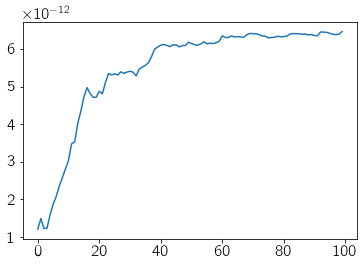

In [1006]:
tscale = 0.1
wavescale = 1.
test = req_closedloop_calc_recursive(G_coron_LO,G_coron_LO_DH,E0_coron,E0_coron_DH,0,0,tscale,flux/100,wavescale**2*QLO,100)
he = test['averaged_hist']
plt.plot(he -contrast_floor)

# MID Modes

MID batch, OBWFS

In [ ]:
tscale = 1.
wavescale = 1.
test = req_closedloop_calc_batch(G_coron_MID,G_OBWFS,E0_coron,E0_OBWFS,0,0,tscale,flux,wavescale**2*QMID,10)
he = test['averaged_hist']
plt.plot(he - contrast_floor)

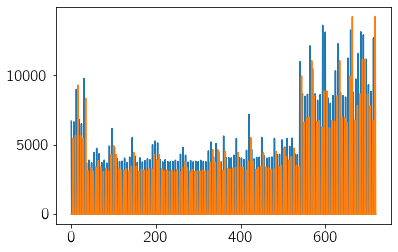

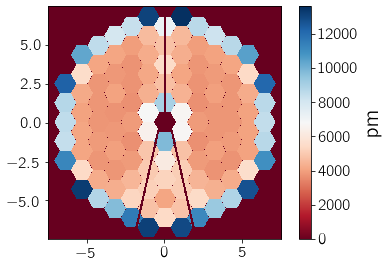

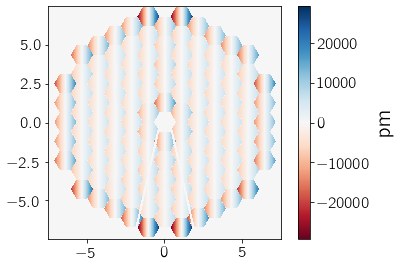

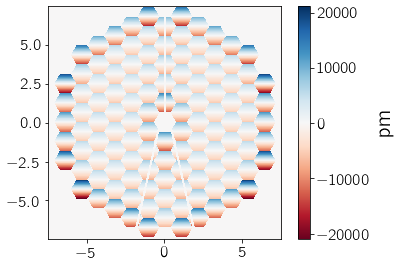

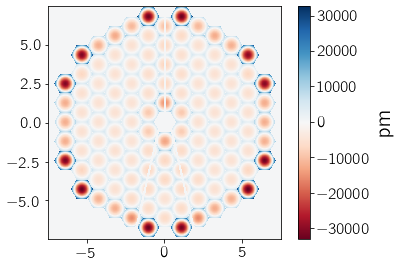

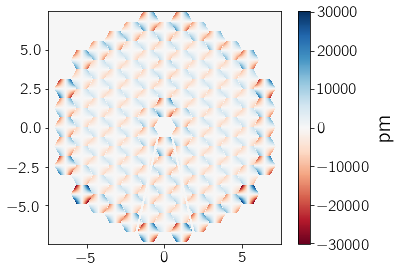

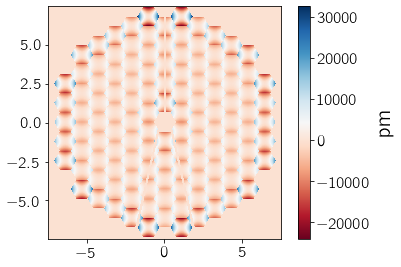

In [1013]:
ho = zernike_coeffs_numaps[0]*1000*600*wavescale
plt.plot(ho)
ho = zernike_coeffs_numaps[4]*1000*600*wavescale
plt.plot(ho)
for pp in range(0,max_MID):
    fig, ax = plt.subplots(ncols=1)
    img1 = hc.imshow_field(nu_maps[pp]/eunit*1000*600*wavescale, cmap='RdBu')#, vmin=pmin, vmax=pmax)
    clb = fig.colorbar(img1)
    clb.set_label('pm', rotation=90)
    plt.tight_layout(h_pad=1)

MID batch, DH

est. contrast 5.229858332954836e-11
est. contrast 5.466832191905601e-11
est. contrast 5.489521817402022e-11
est. contrast 5.5175317410733795e-11
est. contrast 5.5490988109316566e-11
est. contrast 5.567628850794426e-11
est. contrast 5.55233720516153e-11
est. contrast 5.538367878503793e-11
est. contrast 5.5503044063124765e-11
est. contrast 5.551263882293209e-11


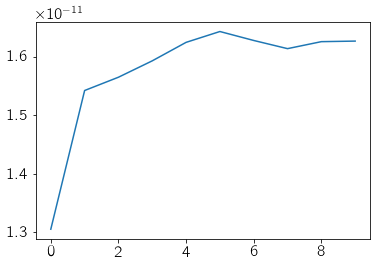

In [1016]:
tscale = 1.
wavescale = 1.
test = req_closedloop_calc_batch(G_coron_MID,G_coron_MID_DH,E0_coron,E0_coron_DH,0,0,tscale,flux,wavescale**2*QMID,10)
he = test['averaged_hist']
plt.plot(he - contrast_floor)

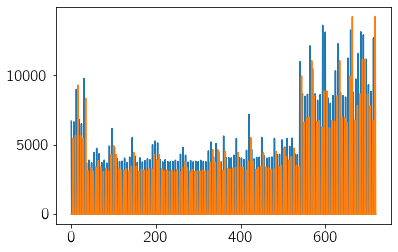

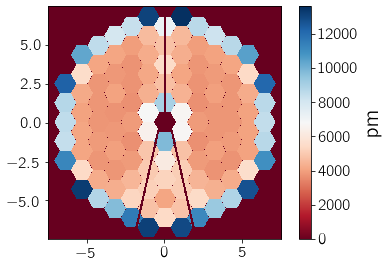

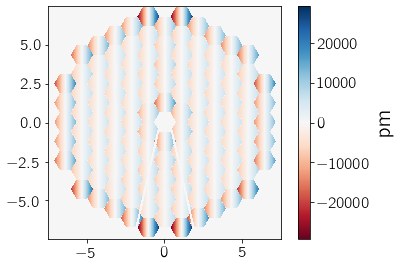

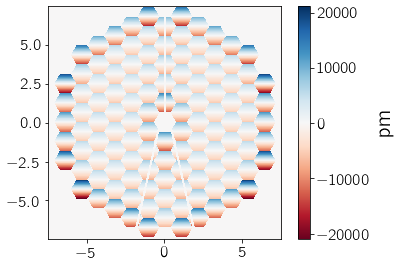

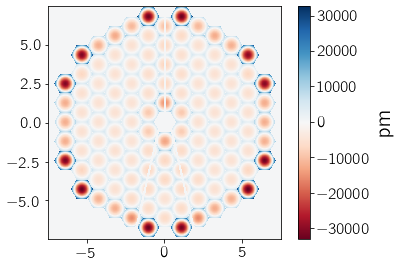

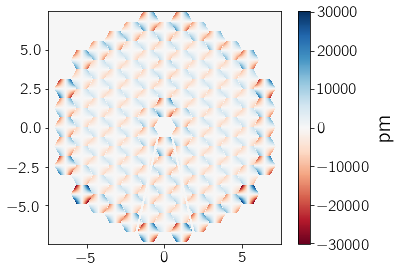

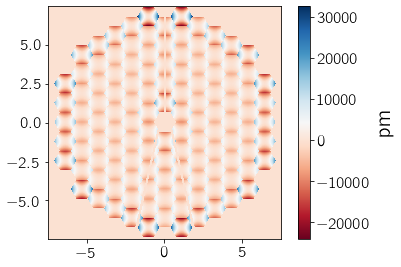

In [1017]:
ho = zernike_coeffs_numaps[0]*1000*600*wavescale
plt.plot(ho)
ho = zernike_coeffs_numaps[4]*1000*600*wavescale
plt.plot(ho)
for pp in range(0,max_MID):
    fig, ax = plt.subplots(ncols=1)
    img1 = hc.imshow_field(nu_maps[pp]/eunit*1000*600*wavescale, cmap='RdBu')#, vmin=pmin, vmax=pmax)
    clb = fig.colorbar(img1)
    clb.set_label('pm', rotation=90)
    plt.tight_layout(h_pad=1)

MID recursive, OBWFS

est. contrast 4.237500186079877e-11
est. contrast 4.2816189095621165e-11
est. contrast 4.306681532451474e-11
est. contrast 4.325389547770564e-11
est. contrast 4.3351140218887296e-11
est. contrast 4.330302257159946e-11
est. contrast 4.3327493611074476e-11
est. contrast 4.3298937146629934e-11
est. contrast 4.332413625415607e-11
est. contrast 4.330213083881974e-11
est. contrast 4.331814716386141e-11
est. contrast 4.331238040979688e-11
est. contrast 4.331718355419677e-11
est. contrast 4.3384392002384224e-11
est. contrast 4.340028228362491e-11
est. contrast 4.341674693381887e-11
est. contrast 4.3409701080008893e-11
est. contrast 4.344160790164445e-11
est. contrast 4.344795359148894e-11
est. contrast 4.345301079383993e-11
est. contrast 4.342354731989048e-11
est. contrast 4.3435065421268806e-11
est. contrast 4.344030483140113e-11
est. contrast 4.344560307956603e-11
est. contrast 4.3443681551213366e-11
est. contrast 4.344580623522417e-11
est. contrast 4.344989669743615e-11
est. contrast 4.3474

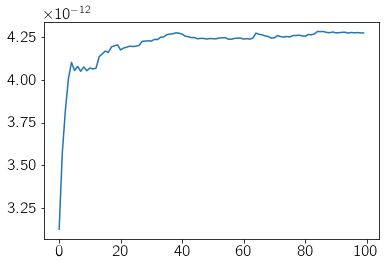

In [1018]:
tscale = 1
wavescale = 0.5
test = req_closedloop_calc_recursive(G_coron_MID,G_OBWFS,E0_coron,E0_OBWFS,0,0,tscale,flux,wavescale**2*QMID,100)
he = test['averaged_hist']
plt.plot(he - contrast_floor)

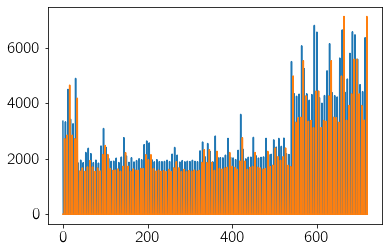

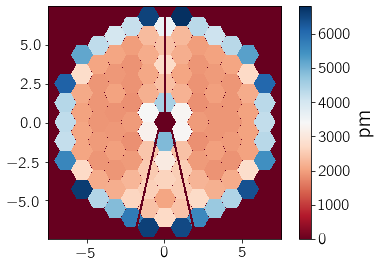

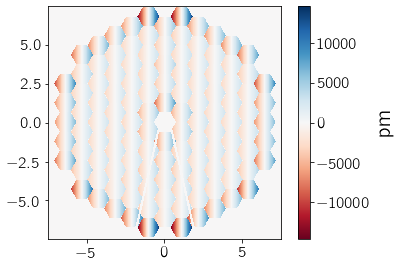

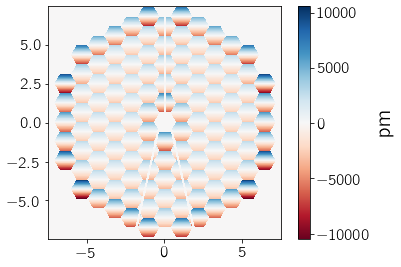

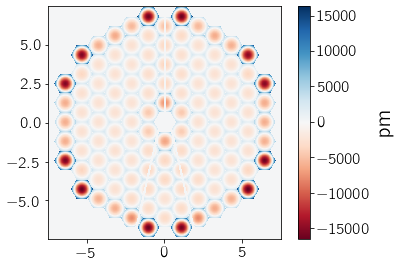

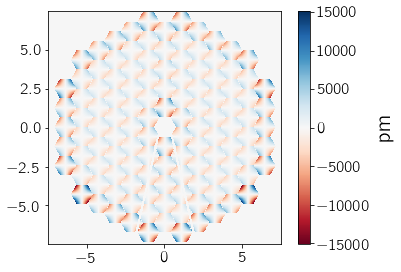

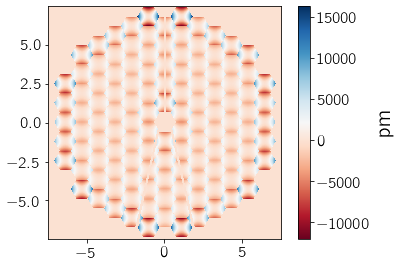

In [1019]:
ho = zernike_coeffs_numaps[0]*1000*600*wavescale
plt.plot(ho)
ho = zernike_coeffs_numaps[4]*1000*600*wavescale
plt.plot(ho)
for pp in range(0,max_MID):
    fig, ax = plt.subplots(ncols=1)
    img1 = hc.imshow_field(nu_maps[pp]/eunit*1000*600*wavescale, cmap='RdBu')#, vmin=pmin, vmax=pmax)
    clb = fig.colorbar(img1)
    clb.set_label('pm', rotation=90)
    plt.tight_layout(h_pad=1)

Mid Recursive DH

est. contrast 4.0567460931971616e-11
est. contrast 4.094910247810269e-11
est. contrast 4.117422493417343e-11
est. contrast 4.141451716374102e-11
est. contrast 4.166273637201385e-11
est. contrast 4.1846200891949203e-11
est. contrast 4.201384222818948e-11
est. contrast 4.2177238152769815e-11
est. contrast 4.236236055660019e-11
est. contrast 4.248674715131804e-11
est. contrast 4.260830962927583e-11
est. contrast 4.2788479770438455e-11
est. contrast 4.2889013230233425e-11
est. contrast 4.298518092075779e-11
est. contrast 4.3087436342462367e-11
est. contrast 4.317360590873135e-11
est. contrast 4.324614261627143e-11
est. contrast 4.333908663673343e-11
est. contrast 4.338132593924122e-11
est. contrast 4.345113179606342e-11
est. contrast 4.348738902288455e-11
est. contrast 4.350332239317743e-11
est. contrast 4.3540951247931425e-11
est. contrast 4.358631219089234e-11
est. contrast 4.357201939812157e-11
est. contrast 4.360601513873426e-11
est. contrast 4.363727939495083e-11
est. contrast 4.36419

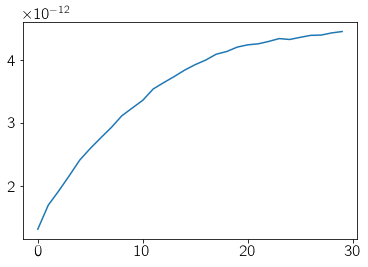

In [1021]:
tscale = 0.1
wavescale = 1.
test = req_closedloop_calc_recursive(G_coron_MID,G_coron_MID_DH,E0_coron,E0_coron_DH,0,0,tscale,flux,wavescale**2*QMID,30)
he = test['averaged_hist']
plt.plot(he - contrast_floor)

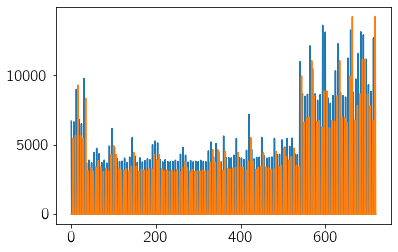

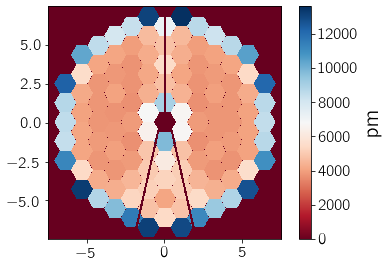

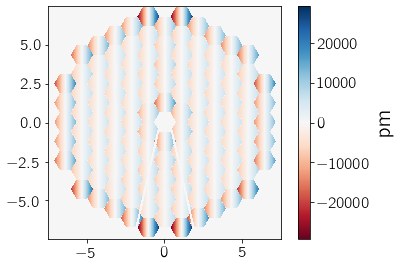

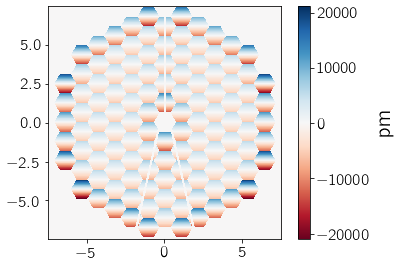

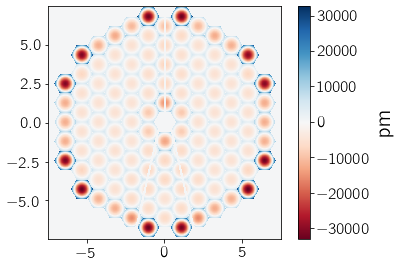

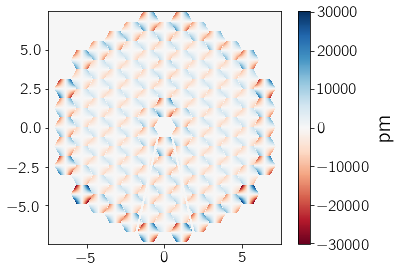

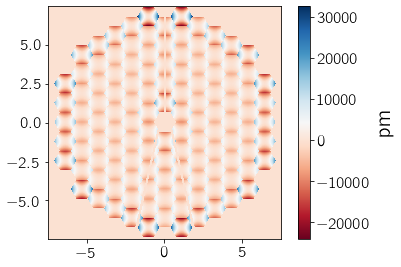

In [1022]:
ho = zernike_coeffs_numaps[0]*1000*600*wavescale
plt.plot(ho)
ho = zernike_coeffs_numaps[4]*1000*600*wavescale
plt.plot(ho)
for pp in range(0,max_MID):
    fig, ax = plt.subplots(ncols=1)
    img1 = hc.imshow_field(nu_maps[pp]/eunit*1000*600*wavescale, cmap='RdBu')#, vmin=pmin, vmax=pmax)
    clb = fig.colorbar(img1)
    clb.set_label('pm', rotation=90)
    plt.tight_layout(h_pad=1)

# HI Modes

HI batch DH

In [1036]:
(15/4)**2

14.0625

est. contrast 4.040839129422581e-11
est. contrast 5.70470081879754e-11
est. contrast 5.913425607673927e-11
est. contrast 6.023957446130047e-11
est. contrast 6.11135799882952e-11
est. contrast 6.164134738763501e-11
est. contrast 6.19606764617416e-11
est. contrast 6.195591035190559e-11
est. contrast 6.224455047674025e-11
est. contrast 6.265653996361262e-11


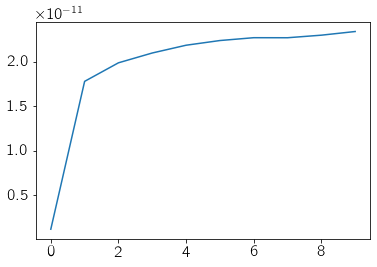

In [1039]:
# tscale = 0.1
# wavescale = 1.
tscale = 100.
wavescale = 0.03
test = req_closedloop_calc_batch(G_coron_HI,G_coron_HI_DH,E0_coron,E0_coron_DH,0,0,tscale,flux/100/10,wavescale**2*QHI,10)
he = test['averaged_hist']
plt.plot(he - contrast_floor)

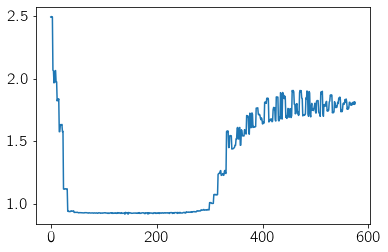

In [1040]:
plt.plot(np.log10(mu_mapHI*1000*600*wavescale))

HI rescursive DH

est. contrast 4.058546635291929e-11
est. contrast 4.0856069579759253e-11
est. contrast 4.107246667482033e-11
est. contrast 4.129907562110233e-11
est. contrast 4.15611431354799e-11
est. contrast 4.1791116283104914e-11
est. contrast 4.19956964526843e-11
est. contrast 4.21362035506034e-11
est. contrast 4.229413196144255e-11
est. contrast 4.2417960979154234e-11
est. contrast 4.249863944753095e-11
est. contrast 4.2558259355386954e-11
est. contrast 4.264861456094216e-11
est. contrast 4.27272434779172e-11
est. contrast 4.2812090393219307e-11
est. contrast 4.2886767877418866e-11
est. contrast 4.296626107697355e-11
est. contrast 4.299966271415754e-11
est. contrast 4.303203258150465e-11
est. contrast 4.3087468165255663e-11
est. contrast 4.312688440765101e-11
est. contrast 4.316091204300948e-11
est. contrast 4.32230172119717e-11
est. contrast 4.326786871236939e-11
est. contrast 4.332515883558079e-11
est. contrast 4.3379192706674125e-11
est. contrast 4.340654216838641e-11
est. contrast 4.341566922

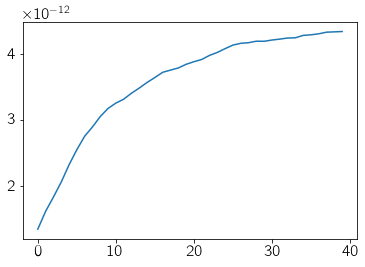

In [1028]:
tscale = 0.1
wavescale = 1.
test = req_closedloop_calc_recursive(G_coron_HI,G_coron_HI_DH,E0_coron,E0_coron_DH,0,0,tscale,flux,wavescale**2*QHI,40)
he = test['averaged_hist']
plt.plot(he - contrast_floor)

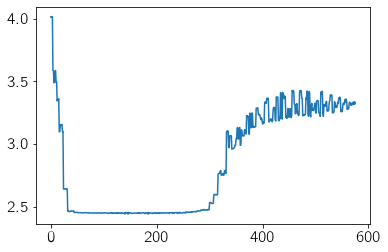

In [1029]:
plt.plot(np.log10(mu_mapHI*1000*600*wavescale))